In [92]:
!pip install transformers datasets --quiet

In [120]:
import pandas as pd 
import numpy as np 
import abc
import matplotlib.pyplot as plt 
import seaborn as sns 

from abc import ABC, abstractmethod
from datasets import Dataset, DatasetDict, load_metric
from sklearn.model_selection import train_test_split
from sklearn.metrics import classification_report
from transformers import AutoTokenizer, AutoModelForSequenceClassification, TrainingArguments, Trainer

sns.set()

In [94]:
# from google.colab import drive 

# drive.mount('/content/drive')

## Препроцессинг и EDA

In [122]:
df = pd.read_csv('/content/drive/MyDrive/project/train_texts.csv') 
df.shape

(1734, 3)

In [123]:
df.head()

,id,text,author
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,Dostoevsky
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",Dostoevsky
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",Dostoevsky
3,3,Мы высказали только главную передовую мысль на...,Dostoevsky
4,4,"I. Отдел литературный. Повести, романы, расска...",Dostoevsky


/usr/local/lib/python3.8/dist-packages/seaborn/_decorators.py:36: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  warnings.warn(


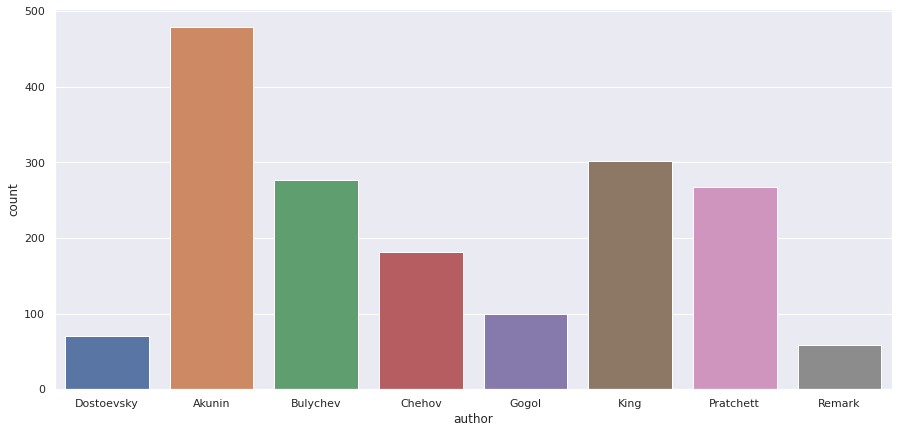

In [124]:
plt.figure(figsize=(15, 7))
sns.countplot(df['author'])

In [98]:
from sklearn.preprocessing import LabelEncoder 

le = LabelEncoder() 
le.fit(df['author']) 
label2id = dict(zip(list(map(str, le.classes_)), list(map(int, le.transform(le.classes_))))) 
id2label = {value: key for key, value in label2id.items()}

label2id

{'Akunin': 0,
 'Bulychev': 1,
 'Chehov': 2,
 'Dostoevsky': 3,
 'Gogol': 4,
 'King': 5,
 'Pratchett': 6,
 'Remark': 7}

In [99]:
df['author'] = LabelEncoder().fit_transform(df['author'].values) 

In [100]:
df.head()

,id,text,author
0,0,-Бабушка!- вскричала малютка.- Возьми меня с с...,3
1,1,"Знал ли Скрудж об этом? Разумеется, знал. Да и...",3
2,2,"-С праздником, дядя, с радостью! Дай вам Бог в...",3
3,3,Мы высказали только главную передовую мысль на...,3
4,4,"I. Отдел литературный. Повести, романы, расска...",3


In [101]:
df_train, df_test = train_test_split(df, test_size=0.3, random_state=42, stratify=df['author']) 

In [102]:
model = "DeepPavlov/rubert-base-cased"

## Классы препроцессинга 

In [103]:
class AbstractPreprocessor(ABC): 
    @abstractmethod
    def preprocess(self, df): 
        raise NotImplementedError

In [104]:
from sklearn.feature_extraction.text import TfidfVectorizer

class SklearnPreprocessor(AbstractPreprocessor): 
    def __init__(self): 
        self.preprocessor = TfidfVectorizer().fit(df['text']) 


    def preprocess(self, df): 
        return self.preprocessor.transform(df['text']), df['author'].values

In [107]:
class HFPreprocessor(AbstractPreprocessor): 
    def __init__(self, model): 
        self.tokenizer = AutoTokenizer.from_pretrained(model) 


    def preprocess(self, df):
        def preprocess_function(texts): 
            return self.tokenizer(texts['text'], truncation=True)

        data = Dataset.from_pandas(df[['text', 'author']])
        _ = data.map(preprocess_function, batched=True)
        return data['text'], data['author']

## Классы моделей

In [109]:
from sklearn.linear_model import LogisticRegression

In [110]:
class AbstractModel(ABC): 
    @abstractmethod 
    def train(self, X, y): 
        raise NotImplementedError


    @abstractmethod
    def predict(self, X): 
        raise NotImplementedError

In [111]:
class SklearnModel(AbstractModel): 
    def __init__(self, model): 
        self.model = model 


    def train(self, X, y): 
        self.model.fit(X, y) 

        
    def predict(self, X): 
        return self.model.predict(X) 

In [112]:
from transformers import default_data_collator

class HFModel(AbstractModel): 
    def __init__(self, model, num_labels, id2label, label2id):
        self.model = AutoModelForSequenceClassification.from_pretrained(
            model, num_labels=num_labels, id2label=id2label, label2id=label2id
        )
        self.tokenizer = AutoTokenizer.from_pretrained(model)


    def train(self, df_train, df_test, args):
        self.trainer = Trainer(
            model=self.model, 
            args=args, 
            train_dataset=df_train, 
            tokenizer=self.tokenizer, 
            data_collator=default_data_collator
        )

        self.trainer.train() 


    def predict(self, X): 
        return self.trainer.predict(X)

## Logger

In [113]:
class Logger(): 
    def __init__(self, y_pred, y_true): 
        self.report_to_print = classification_report(y_true, y_pred)

        report = classification_report(y_true, y_pred, output_dict=True) 
        x = pd.DataFrame(report).transpose().reset_index() 

        x.columns = ['class', 'precision', 'recall', 'f1-score', 'support'] 
        x['class'] = ['Akunin', 'Bulychev', 'Chehov', 'Dostoevsky', 'Gogol', 'King', 'Pratchett', 'Remark', 'accuracy', 'macro avg', 'weighted avg'] 

        self.report = x 


    def print_report(self): 
        print(self.report_to_print)

    
    def __getitem__(self, key): 
        return self.report[self.report['class'] == key]


    def overall_f1_score(self): 
        return self.report[self.report['class'] == 'macro avg']['f1-score'].values[0]


    def overall_precision(self): 
        return self.report[self.report['class'] == 'macro avg']['precision'].values[0]


    def overall_recall(self): 
        return self.report[self.report['class'] == 'macro avg']['recall'].values[0]

## Обучаем логрег

In [114]:
sklearn_prep = SklearnPreprocessor() 

X_train, y_train = sklearn_prep.preprocess(df_train)
X_test, y_test = sklearn_prep.preprocess(df_test) 

In [115]:
logreg = SklearnModel(LogisticRegression(random_state=42, C=0.01, class_weight='balanced')) 
logreg.train(X_train, y_train) 

In [116]:
y_pred = logreg.predict(X_test)

Проверяем, что логгер работает 

In [117]:
logreg_logger = Logger(y_pred, y_test) 
logreg_logger.print_report()

              precision    recall  f1-score   support

           0       0.92      0.93      0.93       144
           1       0.93      0.92      0.92        83
           2       0.80      0.64      0.71        55
           3       0.44      0.67      0.53        21
           4       0.68      0.50      0.58        30
           5       0.90      0.92      0.91        91
           6       0.87      0.93      0.90        80
           7       0.89      0.94      0.91        17

    accuracy                           0.86       521
   macro avg       0.80      0.80      0.80       521
weighted avg       0.86      0.86      0.86       521



In [118]:
logreg_logger['Akunin']

,class,precision,recall,f1-score,support
0,Akunin,0.924138,0.930556,0.927336,144.0


In [119]:
logreg_logger.overall_f1_score()

0.7981427902066309